In [1]:
import pandas as pd # type: ignore
from sklearn.ensemble import RandomForestRegressor # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import root_mean_squared_error, r2_score # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt
import os
from itertools import product

In [2]:
base_dir = os.getcwd()
demandas_path = os.path.join(
    base_dir, "..", "datos", "raw_data", "df_historic_order_demand.xlsx"
)
df_historic_order_demand = pd.read_excel(demandas_path)

In [3]:
# No hay duplicados
df_historic_order_demand[df_historic_order_demand.duplicated()]

,cliente,mes_anio,order_demand


In [4]:
df_historic_order_demand.isna().sum()

cliente          0
mes_anio         0
order_demand    48
dtype: int64

In [5]:
df_historic_order_demand.dropna(inplace=True)

In [6]:
df_historic_order_demand.dtypes

cliente          object
mes_anio         object
order_demand    float64
dtype: object

In [7]:
#20 clientes
df_historic_order_demand["cliente"].unique()

array(['Cliente_1', 'Cliente_2', 'Cliente_3', 'Cliente_4', 'Cliente_5',
       'Cliente_6', 'Cliente_7', 'Cliente_8', 'Cliente_9', 'Cliente_10',
       'Cliente_11', 'Cliente_12', 'Cliente_13', 'Cliente_14',
       'Cliente_15', 'Cliente_16', 'Cliente_17', 'Cliente_18',
       'Cliente_19', 'Cliente_20'], dtype=object)

In [8]:
# Todos los valores son únicos
df_historic_order_demand["mes_anio"].unique

<bound method Series.unique of 0      12-2020
1      12-2020
2      12-2020
3      12-2020
4      12-2020
        ...   
975    12-2024
976    12-2024
977    12-2024
978    12-2024
979    12-2024
Name: mes_anio, Length: 932, dtype: object>

In [9]:
# Como la columna fecha son todo valores únicos, voy a descomponer la columna  en mes y año
df_historic_order_demand["anio"] = df_historic_order_demand["mes_anio"].str.split("-").str[1]
df_historic_order_demand["mes"] = df_historic_order_demand["mes_anio"].str.split("-").str[0]

In [10]:
# Hago una copia del dataframe
df_historico = df_historic_order_demand.copy()

In [11]:
# Como ya he obtenido lo que necesitaba, elimino la columna
df_historico.drop(columns=["mes_anio"], inplace = True)

In [12]:
# Convierto a numéricos
df_historico["anio"]=df_historico["anio"].astype(int)
df_historico["mes"]=df_historico["mes"].astype(int)

<Axes: >

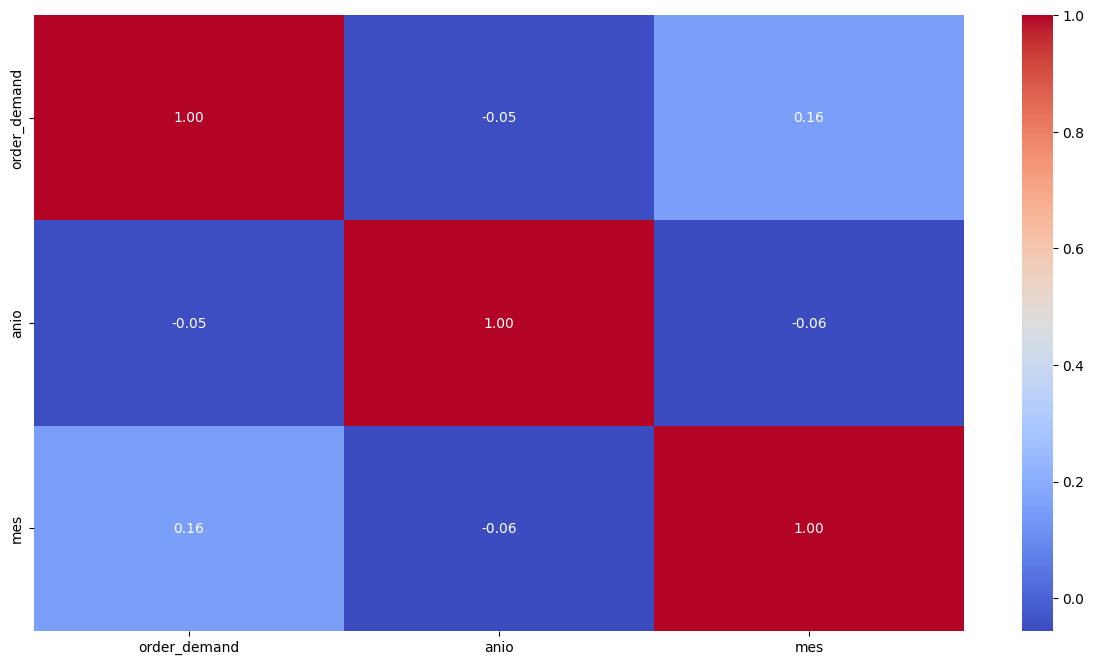

In [13]:
# Hay más relacion con mes que con año
plt.figure(figsize=(15, 8))
correlation_matrix = df_historico.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

## RANDOM FOREST REGRESSOR

In [14]:
# Si le quito el año mejora pero muy muy muy muy levemente la predicción, casi no interesa quitarla
# df_historico = df_historico.drop(columns=["anio"])

In [15]:
# Esto lo hago para encontrar el algoritmo con los mejores parámetros 
# El último que me salga será el mejor

n_arboles = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,50,80,100]
criterion = ["squared_error", "absolute_error", "friedman_mse", "poisson"]
division = [2,3,4,5] # Min samples split


modelos_por_cliente = {}

# Iterar por cada cliente único
for cliente in df_historico["cliente"].unique():
    
    num = float("inf")
    datos_cliente = df_historico[df_historico["cliente"] == cliente]
    X = datos_cliente[["anio", "mes"]]
    y = datos_cliente["order_demand"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2517)
    
    for arbol in n_arboles:
        for criterio in criterion:
            for d in division:
                    
                #n_estimators es el numero de arboles
                regr = RandomForestRegressor(n_estimators=arbol, criterion=criterio, max_depth=5, min_samples_split=d,random_state=2517)
                regr.fit(X_train, y_train)
                predicciones = regr.predict(X_test)
                rmse = root_mean_squared_error(y_test, predicciones)
                r2 = r2_score(y_test, predicciones)
                if rmse < num:
                    rmse_final = rmse
                    r2_final = r2
                    criterio_final = criterio
                    arbol_final = arbol
                    d_final = d
                        
                    num = rmse
            
    # Mejor resultado
    print(f"""{cliente},
            numero_arboles: {arbol_final},
            criterio: {criterio_final},
            min_samples_split: {d_final},
            rmse: {rmse_final},
            r2: {r2_final}""")
    
    # Aplico el modelo con los mejores parámetros obtenidos y lo guardo junto con el cliente
    modelo = RandomForestRegressor(n_estimators=arbol_final, criterion=criterio_final, max_depth=5, min_samples_split=d_final,random_state=2517)
    modelo.fit(X_train, y_train)
    modelos_por_cliente[cliente] = modelo
            
    

Cliente_1,
            numero_arboles: 4,
            criterio: absolute_error,
            min_samples_split: 3,
            rmse: 28.725206700735853,
            r2: 0.9203246831623416
Cliente_2,
            numero_arboles: 28,
            criterio: poisson,
            min_samples_split: 3,
            rmse: 24.310774498200075,
            r2: 0.9486263612362513
Cliente_3,
            numero_arboles: 20,
            criterio: squared_error,
            min_samples_split: 2,
            rmse: 31.172702788980786,
            r2: 0.8875692714099483
Cliente_4,
            numero_arboles: 8,
            criterio: absolute_error,
            min_samples_split: 3,
            rmse: 29.08490399889606,
            r2: 0.9280930241515609
Cliente_5,
            numero_arboles: 50,
            criterio: poisson,
            min_samples_split: 2,
            rmse: 27.085545537806343,
            r2: 0.9288116977945065
Cliente_6,
            numero_arboles: 100,
            criterio: squared_erro

In [16]:
df_prediccion = pd.DataFrame({"anio":[2025], "mes":[1]})
clientes= []
soluciones = []
 
for cliente, modelo in modelos_por_cliente.items():
    # Predecir con el modelo del cliente
    clientes.append(cliente)
    prediccion = modelo.predict(df_prediccion)
    soluciones.append(prediccion[0].round())   # Guardar el valor predicho

df_predicciones_enero = pd.DataFrame({"cliente":clientes,"order_demand":soluciones})

df_predicciones_enero.to_csv("../datos/prediccion/pedidos_2025.csv", index=False)

df_predicciones_enero.head(5)


,cliente,order_demand
0,Cliente_1,725.0
1,Cliente_2,721.0
2,Cliente_3,768.0
3,Cliente_4,743.0
4,Cliente_5,679.0


In [17]:
demandas_path = os.path.join(
    base_dir, "..", "datos", "prediccion", "pedidos_2025.csv"
)

In [18]:
df_predicciones_enero.to_csv(demandas_path, index=False)